In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
import seaborn as sns
sns.set_style("white")
import numpy as np 
import pandas as pd 
from scipy import stats, integrate
import matplotlib.transforms as mtransforms
from matplotlib import gridspec
from itertools import groupby
from operator import itemgetter
from chapter_2_results.tools import Do_df_from_hdf,lolliplot_lolliplot,time_line

In [2]:
 head_filename_result_blocknonans =  'chapter_1_results/head_thorax_data_blk.h5' 
# Load list of bees
head_filename_result = 'chapter_1_results/head_thorax_data.h5'
flight_ids = pd.read_hdf(head_filename_result,key='flight_ids')

In [3]:
def include_nan(DF):
    frames=DF.index.get_level_values('frame_i')
    first_non_nan=frames.min()
    last_non_nan=frames.max()
    DF_nan=DF.reindex(np.arange(first_non_nan,last_non_nan+1)).fillna(np.nan)
    
    return DF_nan
    

In [4]:
DF_traj_head=Do_df_from_hdf(head_filename_result_blocknonans, '/trajectories_filtered/flight_{}/blk_{}','head',flight_ids)
DF_error_head=Do_df_from_hdf(head_filename_result_blocknonans, '/errors_filtered/flight_{}/blk_{}','head',flight_ids)
DF_res_sac_head=Do_df_from_hdf(head_filename_result_blocknonans, '/res_sac/flight_{}/blk_{}','head',flight_ids)
DF_vel_head=Do_df_from_hdf(head_filename_result_blocknonans, '/velocities_filtered/flight_{}/blk_{}','head',flight_ids)

In [5]:
DF_traj_thorax=Do_df_from_hdf(head_filename_result_blocknonans, '/trajectories_filtered/flight_{}/blk_{}','thorax',flight_ids)
DF_error_thorax=Do_df_from_hdf(head_filename_result_blocknonans, '/errors_filtered/flight_{}/blk_{}','thorax',flight_ids)
DF_res_sac_thorax=Do_df_from_hdf(head_filename_result_blocknonans, '/res_sac/flight_{}/blk_{}','thorax',flight_ids)
DF_vel_thorax=Do_df_from_hdf(head_filename_result_blocknonans, '/velocities_filtered/flight_{}/blk_{}','thorax',flight_ids)

# Head and thorax yaw orientation during saccade 


saccadic fight and gaze strategy is expressed in a plethora of animals while moving in their surrounding. we detail in the following the precise head and body coordination at this instance. 
We found that the body initiates the turn and the head is turning only later, but since faster the head ends the saccade earlier.  Such obersvation could also been done in flying blowflies ( Van Hateren and Schilstra  1999)

This movement can remind a dancer doing a pirouette (Hopper et al. 2018, Warren 1989)

In [9]:
def invert_center_interval(interval,window):
    '''function to center the interval around zero, 
    and swap its order so they all increase value along time'''
    if window is None:
        mid_idx=interval.index[0]+len(interval.index)/2
    else:
        mid_idx=interval.index[0]+(window/2)
    middle_value=interval[mid_idx]
    ##center sacc in zero and switch them if needed
    if middle_value>=0:
        interval=interval-middle_value
        if interval[mid_idx-1]>0:
            interval=interval.sort_index(ascending=False)
        else:
            interval=interval    
    else:
        interval=interval+np.abs(middle_value)
        if interval[mid_idx-1]>0:
            interval=interval.sort_index(ascending=False)
        else:
            interval=interval    
    return interval

In [10]:
def center_index_0(idx_to_center,idx_prev,data):
    #idx_nid=saccade[saccade==0].index[0]
    #idx_prev=saccade[saccade<0].idxmax()
    temp=data[idx_to_center:]
    temp.index=np.arange(0,len(temp))
    
    temp1=data[:idx_prev]
    temp1.index=np.arange(-(len(temp1)),0)
    
    
    reindex_data=pd.concat([temp1,temp])
    
    
    return reindex_data

In [11]:
def selection_saccade(res_sac,orient,vel_based,velocities,window=30,seg='body'):
    '''return the saccade defined by the two thresholds method
    input: data of the head and body YPR, and the time window for selection,
    selection centered around the max of the head saccade'''

    ##create empty dataframes to stock all the saccades
    saccades=pd.DataFrame(index=np.arange(-window/2,window/2+1,1))
    speed_sacc=pd.DataFrame()
    ## groupby the head saccades
    grouped_saccades=res_sac.groupby(['blk_i','saccade'])
    ##loop on the saccade groups
    for nbr,(name_sacc,group) in enumerate (grouped_saccades):

        ##check the size if too short
        group=group.reset_index('blk_i',drop=True)
        
        if len(orient.loc[group.index].dropna(how='all'))>=10:

            ##find the index where maximum happen for the head !
            block=vel_based.loc[group.index].zyx
            middle=block.dalpha_2.abs().idxmax()
            ##get the saccade centered around this maximum picked from head           
            saccade=orient.loc[(middle-(window/2)):(middle+(window/2))]
            saccade=saccade.interpolate(method ='linear')
            speed=velocities.zyx.dalpha_2
            speed=speed.loc[(middle-(window/2)):(middle+(window/2))].abs()
            yaw_speed=(np.rad2deg(speed))

            ##make the saccades all centered at zero and increasing in yaw
            saccade=invert_center_interval(saccade.alpha_0,window)
            
            ##feed into a dataframe for this flight
            if saccade[saccade<0].shape[0]==0:
                continue
            else:
                idx_nid=saccade[saccade==0].index[0]
                idx_prev=saccade[saccade<0].idxmax()
                reindex_sac=center_index_0(idx_nid,idx_prev,saccade)
                saccades.loc[:,nbr]=reindex_sac
            
            if seg=='head':

                idx_nid=yaw_speed.idxmax()
                idx_prev=yaw_speed[:idx_nid].index.max()
                reindex_yaw=center_index_0(idx_nid,idx_prev,yaw_speed)
                speed_sacc.loc[:,nbr]=reindex_yaw
                  
            else:
                if len(reindex_sac.index)==len( yaw_speed.index):
                    yaw_speed.index=reindex_sac.index
                    speed_sacc.loc[:,nbr]=yaw_speed
                else:
                    
                    print('different sizes')
            
        else:
           
            continue
        
    return saccades,speed_sacc

In [12]:
DF=pd.DataFrame()
Data_sacc=pd.DataFrame()
DF_all=[]

DF_vel=pd.DataFrame()
Data_sacc_vel=pd.DataFrame()
DF_all_vel=[]

window=30

##loop on each flights to plot the head:
for flight_id in flight_ids:
    
    ##HEAD
    sac_index=DF_res_sac_head.xs(flight_id,level='flight_i')
    
    head_orient=DF_traj_head.xs(flight_id,level='flight_i').zyx
    head_orient=head_orient.reset_index('blk_i',drop=True)
    head_orient=include_nan(head_orient)    
    
    velocities_head=DF_vel_head.xs(flight_id,level='flight_i')
    velocities_head=velocities_head.reset_index('blk_i',drop=True)
    velocities_head=include_nan(velocities_head)    

    df_sacc_head,df_vel_sacc=selection_saccade(res_sac=sac_index,
                                               orient=head_orient,
                                               vel_based=velocities_head,
                                               velocities=velocities_head,
                                               window=window,seg='head')  
    
    ###THORAX
    
    thorax_orient=DF_traj_thorax.xs(flight_id,level='flight_i')
    
    thorax_orient=thorax_orient.zyx
    thorax_orient=thorax_orient.reset_index('blk_i',drop=True)
    thorax_orient=include_nan(thorax_orient)   
    
    
    ##get the velocity for each flight
    velocities_thorax=DF_vel_thorax.xs(flight_id,level='flight_i')
    velocities_thorax=velocities_thorax.reset_index('blk_i',drop=True)
    velocities_thorax=include_nan(velocities_thorax) 
 
    df_sacc_body,df_vel_sacc_body=selection_saccade(res_sac=sac_index,
                                                    orient=thorax_orient,
                                                    vel_based=velocities_head,
                                                    velocities=velocities_thorax,
                                                    window=window,seg='body')  
   
    ##make two multi index
    DF_vel=pd.concat([df_vel_sacc_body,df_vel_sacc],keys=['body', 'head'])
    DF_all_vel.append(DF_vel)
    DF=pd.concat([df_sacc_body,df_sacc_head],keys=['body', 'head'])
    DF_all.append(DF)


Data_sacc=pd.concat(DF_all,keys=flight_ids)
Data_sacc.index.names=['flight_id','seg','frames']


Data_sacc_vel=pd.concat(DF_all_vel,keys=flight_ids)
Data_sacc_vel.index.names=['flight_id','seg','frames']

different sizes
different sizes
different sizes
different sizes
different sizes
different sizes
different sizes
different sizes
different sizes
different sizes


10 ms delay


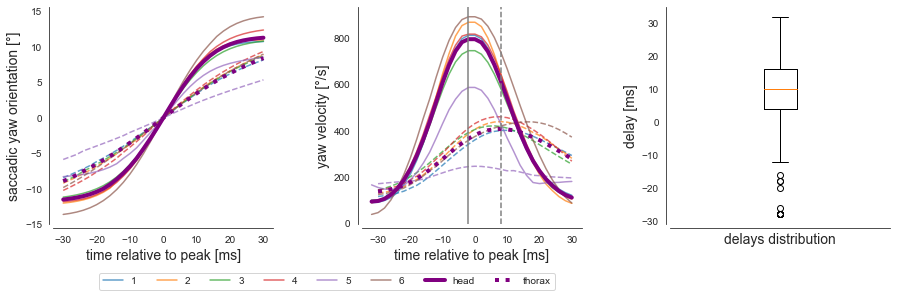

In [13]:
fig,axs=plt.subplots(1,3,figsize=(15,4))
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b']
l_delay=list()
for flight_id,c in zip(flight_ids,colors):
    window=window
    
   
    ##get the mean of all saccades for each flights:
    mu_head_flight=np.rad2deg(Data_sacc.loc[(flight_id,'head')]).mean(axis=1)
    mu_body_flight=np.rad2deg(Data_sacc.loc[(flight_id,'body')]).mean(axis=1)
    mu_vel_head=Data_sacc_vel.loc[(flight_id,'head')].mean(axis=1)
    mu_vel_body=Data_sacc_vel.loc[(flight_id,'body')].mean(axis=1)
    
    A=Data_sacc_vel.loc[(flight_id,'head')].dropna(axis=1).columns
    B=Data_sacc_vel.loc[(flight_id,'body')].dropna(axis=1).columns
    cols=A.intersection(B)
    
    maxs_head=Data_sacc_vel.loc[(flight_id,'head'),cols].dropna(axis=1).idxmax(axis=0).values
    maxs_body=Data_sacc_vel.loc[(flight_id,'body'),cols].dropna(axis=1).idxmax(axis=0).values

    delays=(maxs_body-maxs_head)
    
    
    for i in delays:
        l_delay.append(i/500*1000)
    
    names_for_publi={'05':1,'06':2,'07':3,'08':4,'11':5,'17':6}
    
    if mu_vel_head.shape[0]==0:
        continue
        
    else:
        a_val=0.7
        
        axs[1].plot(mu_vel_head.index*2,mu_vel_head*500,
                    color=c,alpha=a_val,linewidth=1.5,
                    label=names_for_publi[flight_id])
        axs[0].plot(mu_head_flight.index*2,mu_head_flight,
                    color=c,alpha=a_val,linewidth=1.5,
                    label=names_for_publi[flight_id])

        axs[1].plot(mu_vel_body.index*2,mu_vel_body*500,
                    color=c,linewidth=1.5,alpha=a_val,linestyle='--')
        axs[0].plot(mu_body_flight.index*2,mu_body_flight,
                    color=c,linewidth=1.5,alpha=a_val,linestyle='--')  
        
          

##get the mean of all flights    
avg_head=Data_sacc.unstack(0).mean(axis=1).loc['head']
avg_body=Data_sacc.unstack(0).mean(axis=1).loc['body']     

##convert in degrees
avg_head=np.rad2deg(avg_head)
avg_body=np.rad2deg(avg_body)

##get the velocity
avg_vel_head=Data_sacc_vel.unstack(0).mean(axis=1).loc['head']
avg_vel_thorax=Data_sacc_vel.unstack(0).mean(axis=1).loc['body']     
avg_vel_head=avg_vel_head*500
avg_vel_thorax=avg_vel_thorax*500


axs[1].plot(avg_vel_head.index*2,avg_vel_head,color='purple',linewidth=4,label='head',alpha=1)
axs[1].plot(avg_vel_thorax.index*2,avg_vel_thorax,color='purple',linewidth=4,linestyle=':',label='thorax',alpha=1)
axs[0].plot(avg_head.index*2,avg_head, color='purple',linewidth=4,label='mean head',alpha=1)
axs[0].plot(avg_body.index*2,avg_body, color='purple',linewidth=4,linestyle=':',label='mean thorax',alpha=1)

maxi=avg_vel_thorax.idxmax()
maxih=avg_vel_head.idxmax()
axs[1].axvline(maxi*2,color='grey',linestyle='--')
print(np.abs(maxi*2-maxih*2),'ms delay')

axs[1].axvline(maxih*2,color='grey')

axs[0].set_ylabel('saccadic yaw orientation [°]',fontsize=14)
axs[0].set_xlabel('time relative to peak [ms]',fontsize=14)
axs[1].set_xlabel('time relative to peak [ms]',fontsize=14)


axs[2].boxplot(np.asarray(l_delay))
axs[2].set_xlabel('delays distribution',fontsize=14)
axs[2].set_ylabel('delay [ms]',fontsize=14)
axs[2].set_xticks([])

lgd=axs[1].legend(ncol=8, loc=0,bbox_to_anchor=(0.9, -0.2))
axs[1].set_ylabel('yaw velocity [°/s]',fontsize=14)
sns.despine(offset=4)
fig.subplots_adjust(wspace=0.4)

#fig.savefig(fig_folder+'saccade_yaw.png',dpi=400, bbox_extra_artists=(lgd,), bbox_inches='tight')


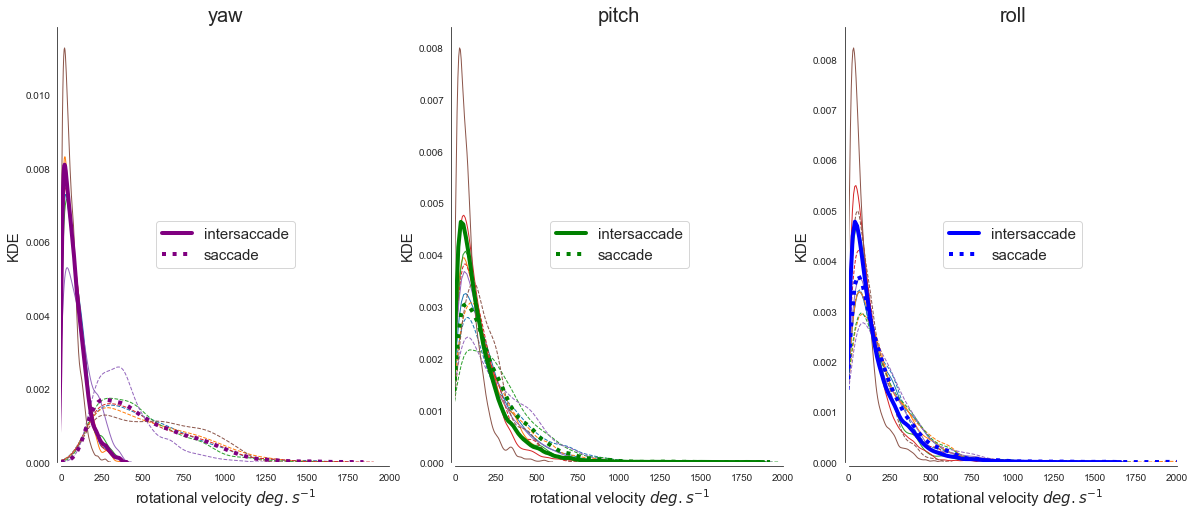

In [14]:
subset=np.nan
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b']

fig,axes=plt.subplots(1,3,figsize=(20,8))


for angle,ax,colorM,name in zip( ['dalpha_2','dalpha_1','dalpha_0'],axes.ravel(),['purple','green','blue'],['yaw','pitch','roll']):
    
    for flight_id,c in zip(flight_ids,colors):
        velocities_head=DF_vel_head.xs(flight_id,level='flight_i')
        velocities_head=velocities_head.reset_index('blk_i',drop=True)
        velocities_head=include_nan(velocities_head)   
        
        res_head=DF_res_sac_head.xs(flight_id,level='flight_i')
        res_head=res_head.reset_index('blk_i',drop=True)
        intersac_index = res_head.loc[res_head.intersac.dropna().index,:].index
        sac_index = res_head.loc[res_head.saccade.dropna().index,:].index
        # Subset to the flight
        velocities_head=velocities_head.zyx
        ang=velocities_head.loc[intersac_index,angle]
        ang=ang*180/np.pi
        ang*=500
        sns.distplot(np.abs(ang), hist = False,kde=True,kde_kws = {'linewidth': 1,"color": c},ax=ax)
        
         # Subset to the flight
      
        ang_sac=velocities_head.loc[sac_index,angle]
        ang_sac=ang_sac*180/np.pi
        ang_sac*=500
        # Draw the density plotµ
        sns.distplot(np.abs(ang_sac), hist = False,kde=True,
                     kde_kws = {'linewidth': 1,'linestyle':'--',"color": c},
                    ax=ax)
        
    ax.set_xlim(0,2000) 
    
    all_head_inter_idx=DF_res_sac_head.intersac.dropna().index
    vel_head=DF_vel_head.zyx
    all_head_inter=vel_head.loc[all_head_inter_idx,[angle]]
    all_head_inter=all_head_inter*180/np.pi
    all_head_inter=all_head_inter*500

    sns.distplot(np.abs(all_head_inter), hist = False, kde = True,
                 kde_kws = {'linewidth':4,'alpha': 1},
               color=colorM,ax=ax,label='intersaccade')
    
    
    
    all_head_sacc_idx=DF_res_sac_head.saccade.dropna().index
    vel_head=DF_vel_head.zyx
    all_head_sacc=vel_head.loc[all_head_sacc_idx,[angle]]
    all_head_sacc=all_head_sacc*180/np.pi
    all_head_sacc=all_head_sacc*500

    sns.distplot(np.abs(all_head_sacc), hist = False, kde = True,
                 kde_kws = {'linewidth':4,'alpha': 1,'linestyle':':'},
               color=colorM,ax=ax,label='saccade')
    
    ax.legend(loc='center', fontsize=15)
    ax.set_title('{}'.format(name),fontsize=20)
    ax.set_xlabel('rotational velocity $deg.s^{-1}$',fontsize=15)
    ax.set_ylabel('KDE',fontsize=15)
      
sns.despine(offset=4)

#fig.savefig(fig_folder+'head_rot_speed.png',dpi=400)

# Difference between head and thorax orientation

During intersaccade head and thorax behaved also differently as the thorax is less stabilized.

wWE provide here an illustration to describe how head and thorax behaved differently along yaw orientation during intersaccade

In [16]:
def Diff_angle(x,y):
    ans=np.arctan2(np.sin(x-y), np.cos(x-y))
    res=np.rad2deg(ans)
    return res

In [17]:
fmin=3350 
fmax=4100
flight_id='07'

angle='alpha_0'
##HEAD
head_orient_sample=DF_traj_head.xs(flight_id,level='flight_i').zyx
head_orient_reidx=head_orient_sample.reset_index('blk_i',drop=True)
head_orient_reidx=include_nan(head_orient_reidx) 
#get interasccades
sac_index=DF_res_sac_head.xs(flight_id,level='flight_i')
sac_index=sac_index.reset_index('blk_i',drop=True)

intersac_index = sac_index.loc[sac_index.intersac.dropna().index,:].index
orientation_head=head_orient_reidx.loc[fmin:fmax]

## THORAX
body_orient=DF_traj_thorax.xs(flight_id,level='flight_i').zyx
body_orient=body_orient.reset_index('blk_i',drop=True)
body_orient=include_nan(body_orient)    
orientation_body=body_orient.loc[fmin:fmax]


## MAKE THE DIFF
diff_angle=Diff_angle(orientation_head.loc[:,angle],orientation_body.loc[:,angle])
        

In [18]:
def ranges(nums):
    '''get block of consevutives for fill inbetween'''
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))

C:\Users\localadmin\Documents\Charlotte\proj-HeadBodyBumblebees-true\Head_thorax_Data\Head_thorax_Data\tools.py:231: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  yaw_rest=yaw.loc[index_rest]#.loc[::step]
C:\Users\localadmin\Documents\Charlotte\proj-HeadBodyBumblebees-true\Head_thorax_Data\Head_thorax_Data\tools.py:257: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  yaw_cond=yaw.loc[conditional_index]#.iloc[::step]


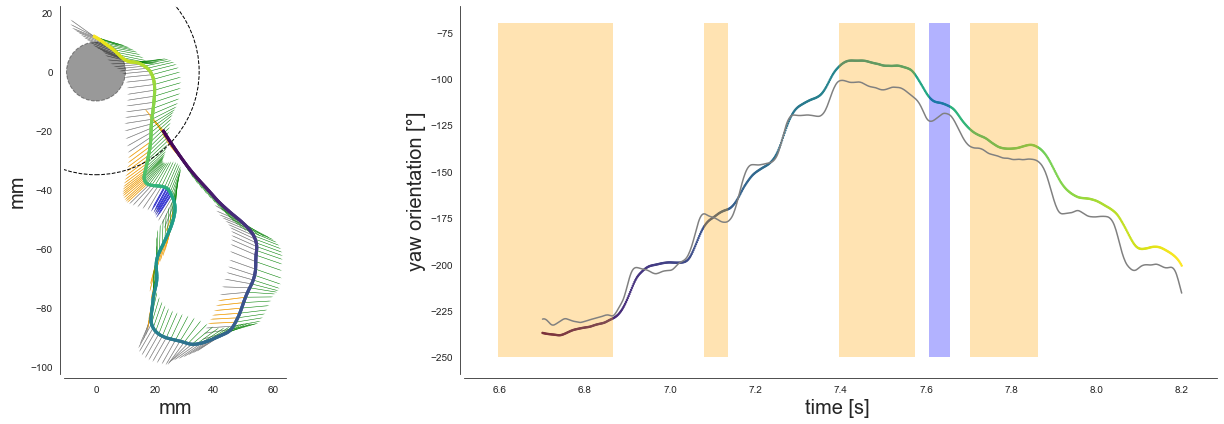

In [21]:
# Add the thorax to the plot:
cmap='viridis'
fig,axes=plt.subplots(1,2,figsize=(20,6))
ax=axes[0]
##get the flight
data=DF_traj_head.xs(flight_id,level='flight_i')
data=data.reset_index('blk_i',drop=True)
##get the saccade index
data_res=DF_res_sac_head.xs(flight_id,level='flight_i')
data_res=data_res.reset_index('blk_i',drop=True)
##downsampling rate for plot
step=5
##define colros for the different saccades and intersaccades

#start
start_seg=fmin
#the end
end_seg=fmax

##extract xyz and orientation
df_traj=data.location
df_orient=data.zyx

xyz=df_traj.loc[start_seg:end_seg,['x','y']]
orient=df_orient.loc[start_seg:end_seg,['alpha_0']]

##get the index of the saccades
block=data_res.loc[start_seg:end_seg]
condition_index=block[(block.intersac.isna()) & (block.saccade.notna())].index


#get intersaccade with drift above >0
head_filename_result_blocknonans =  'chapter_1_results/head_thorax_data_blk.h5' 
key = '/blk_nonans/flight_{}'.format(flight_id) 
test_data={}
blknonans = pd.read_hdf(head_filename_result_blocknonans,key)

dic_block={}

for b in blknonans.index:

    df=pd.read_hdf('chapter_2_results/idealmotion.hdf',key= '/trajectories_constantdrift_param/flight_{}/blk_{}'.format(flight_id,b))

    dic_block[b]=df.loc[:,'drift']
    
test_data=pd.concat(dic_block)  

list_interssacade=data_res.loc[start_seg:end_seg].intersac.dropna().unique()
drift=test_data.loc[0,list_interssacade]*180/np.pi

## get drift above 

std=5
A=drift[drift>std].reset_index(0)
intersaccade_pivot=A.index
nbs=intersaccade_pivot.to_list()
condition_index_above=data_res[data_res['intersac'].isin(nbs)].index
colors=['grey','blue']

lc=lolliplot_lolliplot(ax,condition_index_above,xyz,orient,colors,alphas=[0.5,1],seg='thorax',step=step,ds_which='both',cmap=cmap,lw=5)


## get drift below 

B=drift[drift<-std].reset_index(0)
intersaccade_pivot=B.index
nbs=intersaccade_pivot.to_list()
condition_index_below=data_res[data_res['intersac'].isin(nbs)].index
colors=['grey','orange']
alphas=[1,1]

lc=lolliplot_lolliplot(ax,condition_index_below,xyz,orient,colors,alphas=alphas,seg='thorax',step=step,ds_which='both',cmap=cmap,lw=5)


ax1=axes[1]
time=orientation_body.index/500

ax1.plot(time,np.rad2deg(orientation_head.alpha_0),color='grey')
ax1.scatter(x=time,y=np.rad2deg(orientation_body.alpha_0),c=time,cmap=cmap,s=2)

blocks=ranges(condition_index_below)

for b in blocks:
    ax1.fill_between([b[0]/500,b[1]/500], -250, -70,facecolor='orange', alpha=0.3, linewidth=0)

blocks=ranges(condition_index_above)

for b in blocks:
    ax1.fill_between([b[0]/500,b[1]/500], -250, -70,facecolor='blue', alpha=0.3, linewidth=0)


ax1.set_ylabel('yaw orientation [°]',fontsize=20)
ax1.set_xlabel('time [s] ',fontsize=20)

#thorax:
##get the flight
data=DF_traj_thorax.xs(flight_id,level='flight_i')
data=data.reset_index('blk_i',drop=True)
##downsampling rate for plot
step=5
##define colros for the different saccades and intersaccades
colors=['green','green']
##extract orientation
df_orient=data.zyx
orient=df_orient.loc[fmin:fmax,['alpha_0']]
##get the index of the saccades
block=data_res.loc[fmin:fmax]
lc=lolliplot_lolliplot(ax,None,xyz,orient,colors,seg='head',step=step,ds_which='both',cmap=cmap,lw=5)

circle2 = plt.Circle((0, 0), 10, color='k', fill=True,alpha=0.4,linestyle='--')
ax.add_artist(circle2)
circle2 = plt.Circle((0, 0), 35, color='k', fill=False,linestyle='--')

ax.add_artist(circle2)

ax.set_xlim(xyz.x.min()-10,xyz.x.max()+10)
ax.set_ylim(xyz.y.min()-10,xyz.y.max()+10)
ax.set_xlabel('mm',fontsize=20)
ax.set_ylabel('mm',fontsize=20)
ax.set_aspect('equal')
sns.despine(offset =4)
fig.tight_layout()

